# Term-Project

## Abhimanyu Joshi

### UTA ID : 1001796557

<B>Aim: </B>
<br>
The aim of this project is to build a text classifier that would predict the rating for a review based on the text available for the review. I have used several classifiers and compared there performances as well as built a review-prediction model.

## Data collection

<font size=4>The datasets from './boardgamegeek-reviews/bgg-13m-reviews.csv' contains six columns(index, user, rating, comment, ID, name). But only two columns will be used for this task which is rating and comment. After this two columns are chosen, there are still some NaNs in the datasets.</font>

<B>Imports for the project.</B>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import nltk
import random
import matplotlib.mlab as mlab
import math
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import sklearn.metrics as metrics
import tensorflow as tf
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading Data
<br>
<B>Loading up the boardgamegeek-reviews dataset.</B> I removed the unwanted columns to increase the efficiency.

In [2]:
data_frame = pd.read_csv('bgg-15m-reviews.csv', index_col=0)
data_frame.drop(data_frame.columns[4], axis=1, inplace=True)
data_frame.drop(data_frame.columns[3], axis=1, inplace=True)
data_frame.drop(data_frame.columns[0], axis=1, inplace=True)
print(data_frame.head())
data_frame.shape

   rating                                            comment
0    10.0                                                NaN
1    10.0  Hands down my favorite new game of BGG CON 200...
2    10.0  I tend to either love or easily tire of co-op ...
3    10.0                                                NaN
4    10.0  This is an amazing co-op game.  I play mostly ...


(15823269, 2)

There are a large number of rows which contains NaN as an entry and are required to be removed to increase the efficiency.

In [3]:
data_frame.dropna(subset = ["comment"], inplace=True)

reduced = data_frame
reduced.head

<bound method NDFrame.head of           rating                                            comment
1           10.0  Hands down my favorite new game of BGG CON 200...
2           10.0  I tend to either love or easily tire of co-op ...
4           10.0  This is an amazing co-op game.  I play mostly ...
5           10.0  Hey! I can finally rate this game I've been pl...
8           10.0  Love it- great fun with my son. 2 plays so far...
...          ...                                                ...
15823242    10.0        KS Collector's Bundle with a friend of mine
15823247    10.0                                Belekokio Gerumo...
15823253    10.0                    Excelente!! lo mejor que probé.
15823264     8.0  Turn based preview looks very promising. The g...
15823265     8.0                                                 KS

[2995023 rows x 2 columns]>

Since it is impossible to host the complete dataset on pythonanywhere and also computing the values for approximately 3 Million entries was a very time and resource extensive job, so I have trimmed down the dataset to <B>100,000</B> entries which is much more easy to process and upload for the project.

In [4]:
sample_size = 100000
sample_frame = reduced.sample(n=sample_size)
sample_frame = shuffle(sample_frame)
sample_frame

,rating,comment
6177913,6.0,Searching ebay I found this game from my child...
11329447,6.5,Nice little game. Good for teaching kids geog...
15167445,4.0,Nice fresh idea of controlling the dark hordes...
4252043,8.0,New
13043216,6.0,Funny short disc collecting game.
...,...,...
14012219,7.0,Amazing art. We have really only played one o...
15538814,7.0,Based on one play: Fairly enjoyable game where...
3060961,6.7,"Fun game, but I would enjoy it much more if th..."
154852,10.0,"Well, at 49 years of age, I got a new favourit..."


## Data Filtering

As it's understandable that the data has shrunked <B>from 3-Million to merely 100,000 entries</B> but I would say that it's still a good data size to work with. Also, since there were <B>less than 10 </B> entries with <B>Rating=0</B> so it was a good option to filter them out and have a more even spread of data among the rest of the remaing ratings $[1-10]$.
<br>
Also here we can see the break down of frequencies of each rating.

In [5]:
reduced["rating"] = reduced["rating"].round(0).astype(int)
reduced.groupby(["rating"]).count()

,comment
rating,
0,9
1,23513
2,45046
3,79101
4,151068
5,242647
6,587568
7,650409
8,751962


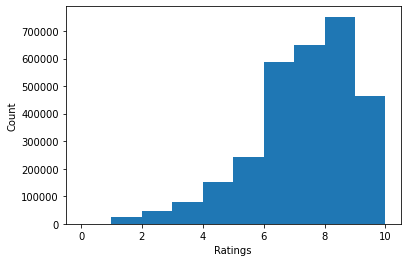

In [6]:
import matplotlib.pyplot as plt
plt.hist(reduced.rating)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()



In [7]:
sample_frame["rating"] = sample_frame["rating"].round(0).astype(int)
sample_frame.groupby(["rating"]).count()

,comment
rating,
1,759
2,1605
3,2631
4,5094
5,8007
6,19681
7,21772
8,24939
9,9336


We can see there is a concentration of ratings in range of $['6-8']$ which makes a perfect sense but also makes our job a little bit harder to train a classifier on such a heavily biased data. But since these are the raw figures from the original cleaned data (removed NaN) so I tried to maintain this ratio while tranning my classifiers.

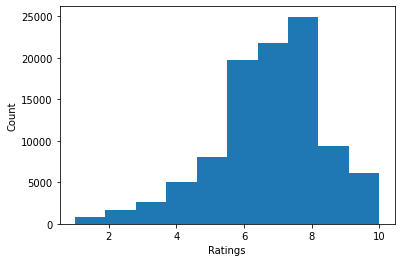

In [8]:
import matplotlib.pyplot as plt
plt.hist(sample_frame.rating)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


## Data Pre-processing

### Filtered Data
There were <B>15.8-Million</B> rows of data in the original dataset out of which nearly <B>12-Million</B> were removed due to NaN values. After that we had a dataset of approx <B>3-Million rows and 5 columns</B> which has been shrunk down to a sample of size <B>100,000 rows and 2 columns $['rating','comment']$</B>

### StopWords
Stopwords are the most commonly appearing words like punctuations (a, an, the etc.) which barely generate any value for text-classification, so we used nltk to find and remove the stop words from our data.

### General pre-processing methods
The first step is to uniform text format to lower-case, then we used tokenization which is the task of chopping words up into pieces, called tokens and during this process I also removed the punctuations from the data.<B> For Stemming </B> I used Porter Stemmer which very well for the English Language. It helps to reduce complexity while retaining the basic meaning of the words.

<B>Here I also generated two numpy arrays from the data to again reduce the size and for further use in the project.</B>

In [9]:
x = np.array(sample_frame.comment)
np.random.shuffle(x)
y = np.array(sample_frame.rating)
np.random.shuffle(y)

text_data = []
for index, text in tqdm(enumerate(x)):
    # lower case
    text = text.lower()
    # tokenize
    words = word_tokenize(text)
    # topwords
    words = [w for w in words if w not in stopwords.words('english')]
    # remove punctuation
    words = [w for w in words if w not in string.punctuation]
    # Stemming
    words = [PorterStemmer().stem(w) for w in words]
    text_data.append(words)

x = np.array(text_data, dtype=object)
np.save('x_new.npy', x)
np.save('y_new.npy', y)


442it [00:02, 154.71it/s]


KeyboardInterrupt: 

## Tf-idf

The dataset is first devided into train data and test data with a test size of 20%, then I vectorized the data to be used for Tf-idf to assign a weight to each word in oreder to help us assess the importance of a word in relation to a document or a document to a corpus.

In [11]:
import numpy as np
print('load data')

x = np.load('x_new.npy', allow_pickle=True)
y = np.load('y_new.npy', allow_pickle=True)

for i, d in tqdm(enumerate(x)):
    sentence = ' '.join(x[i])
    x[i] = sentence
   
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


count_vect = CountVectorizer(min_df=0.001, max_df=0.5, max_features=1500)
X_train_counts = count_vect.fit_transform(x_train)
X_test_counts = count_vect.fit_transform(x_test)

count_vect = TfidfTransformer()
tf_transformer = TfidfTransformer().fit(X_train_counts)
x_train = tf_transformer.transform(X_train_counts)

x_train = x_train.toarray()
print(x_train.shape)
print(y_train.shape)

tf_transformer = TfidfTransformer().fit(X_test_counts)
x_test = tf_transformer.transform(X_test_counts)


load data


100000it [00:00, 550438.65it/s]


(80000, 1500)
(80000,)


## Decision tree

I used $sklearn$ to import DecisionTreeClassifier method with <B>criterion:</B> “gini” for the Gini impurity

In [12]:
def decision_tree(train_x, train_y, test_x, test_y):
    print('...Decision_tree...')
    clf = DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_split=20, min_samples_leaf=5).fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print('Decision tree accuracy: ', metrics.accuracy_score(test_y, predict_y))


decision_tree(x_train, y_train, x_test, y_test)

...Decision_tree...
Decision tree accuracy:  0.2557


### Naive-Bayes

<B>MultinomialNB</B> function is loaded from $sklearn$ . The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.

In [13]:
def bayes_fit_and_predicted(train_x, train_y, test_x, test_y):
    print('...Bayes...')
    clf = MultinomialNB(alpha=1.0).fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print('Bayes accuracy: ', metrics.accuracy_score(test_y, predict_y))
    
bayes_fit_and_predicted(x_train, y_train, x_test, y_test)

...Bayes...
Bayes accuracy:  0.24015


### SVM

<B>SVM</B> or Support Vector Machine is a set of supervised learning methods used for classification, regression and outliers detection. The support vector machines in scikit-learn support both dense (numpy.ndarray and convertible to that by numpy.asarray) and sparse (any scipy.sparse) sample vectors as input.

In [14]:
def svm_fit_and_predicted(train_x, train_y, test_x, test_y, C=1.0):
    print('...SVM...')
    clf = LinearSVC(C=1.0, penalty='l2').fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print('SVM accuracy: ', metrics.accuracy_score(test_y, predict_y))

svm_fit_and_predicted(x_train, y_train, x_test, y_test)  

...SVM...
SVM accuracy:  0.22535


## CNN using keras

Keras is a higher level library which operates over either TensorFlow or Theano, and is intended to stream-line the process of building deep learning networks. 

I have less experience working with neural-nets so the accuracies are pretty poor but it's always a good experience to learn something new and try to implement it in a project. Here I built a sequential model using Keras <B>Convolutional, Activation, Max-pooling and dense</B> layers with <B> relu and sigmoid </B> activation functions with $Adam$ optimizer and $crossentropy_loss$.

In [15]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers


os.environ['CUDA_VISIBLE_DEVICES'] = "0"

MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 500
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

print('load data')

x = np.load('x_new.npy', allow_pickle=True)
y = np.load('y_new.npy', allow_pickle=True)



x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
# tokenizer.fit_on_texts(x_test)
# x_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index



x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,padding='post', maxlen=MAX_SEQUENCE_LENGTH)
#x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,padding='post', maxlen=MAX_SEQUENCE_LENGTH)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words
                                    , output_dim= EMBEDDING_DIM
                                    ,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                                    ,mask_zero=True
                                    , input_length=MAX_SEQUENCE_LENGTH))


# inputs = tf.keras.Input(shape=(None,), dtype="int64")

# x = tf.keraslayers.Embedding(num_words, EMBEDDING_DIM)(inputs)

model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


#predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

#model = tf.keras.Model(inputs, predictions)

# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3))
# #model.add(tf.keras.layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# #model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid', name="predictions"))

#model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

#print(x_train[0,:])


model.fit(x_train, y_train, batch_size=100, epochs=3, validation_split=VALIDATION_SPLIT)

# model save
model.save('cnn.h5')

x_test = tokenizer.texts_to_sequences(x_test)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

results = model.evaluate(x_test, y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])










load data
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           25000     
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 58,429
Trainable params: 58,429
Non-trainable params: 0
__________________________________________

Epoch 1/5
1600/1600 [==============================] - 14s 9ms/step - loss: -15.7215 - accuracy: 0.0077 - val_loss: -20.4554 - val_accuracy: 0.0072
Epoch 2/5
1600/1600 [==============================] - 14s 9ms/step - loss: -25.0941 - accuracy: 0.0077 - val_loss: -29.8506 - val_accuracy: 0.0072
Epoch 3/5
1600/1600 [==============================] - 15s 10ms/step - loss: -34.4786 - accuracy: 0.0077 - val_loss: -39.2661 - val_accuracy: 0.0072
Epoch 4/5
1600/1600 [==============================] - 15s 9ms/step - loss: -43.8806 - accuracy: 0.0077 - val_loss: -48.6922 - val_accuracy: 0.0072
Epoch 5/5
1600/1600 [==============================] - 15s 10ms/step - loss: -53.2892 - accuracy: 0.0077 - val_loss: -58.1227 - val_accuracy: 0.0072
Training Accuracy: 0.0077
Testing Accuracy:  0.0072
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


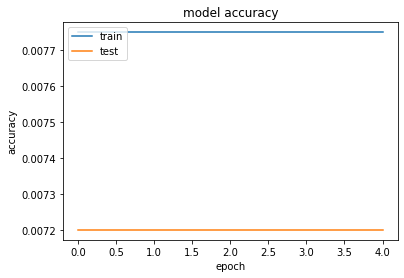

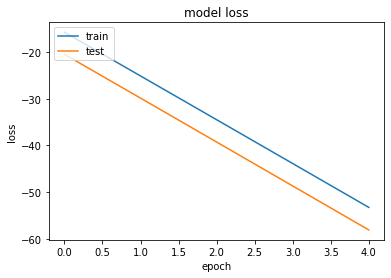

In [16]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(x_test, y_test),
                    batch_size=50)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words, 
                           output_dim=EMBEDDING_DIM, 
                           input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           25000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 75,021
Trainable params: 75,021
Non-trainable params: 0
_________________________________________________________________


In [21]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = tf.keras.models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [22]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'


print('load data')

x = np.load('x_new.npy', allow_pickle=True)
y = np.load('y_new.npy', allow_pickle=True)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)



tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)



param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = tf.keras.models.Sequential()
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)



grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=2, verbose=1, n_iter=2)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test, y_test)



s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
    source,
    grid_result.best_score_,
    grid_result.best_params_,
    test_accuracy)
print(output_string)


load data
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


# Conclusion

### Decision tree accuracy:  0.2557

### Bayes accuracy:  0.24015

### SVM accuracy:  0.22535

<B> the experiment with cnn failed miserably <B>

## Chalanges:

First and the biggest challenge was the size of data, I have tried to compute the whole 15 million rows of data and failed due to system memory crash or google colab max_ram_limit crash. 

Working on local machine was a bit hard since my mac doesn't have GPU support, just trying again and again with different parameter for neural-net trainning was tough.

Working with a small sample of data seemed to have affected the accuracy pretty badly.

Trying to come-up with a good cnn learning model is still tough for me, surely need to study more on that.

## References:

<a>https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f</a>

<a>https://realpython.com/python-keras-text-classification/</a>
<a>https://www.kaggle.com/jvanelteren/boardgamegeek-reviews/notebooks</a>

<a>https://www.tensorflow.org/api_docs/python/tf/keras/</a>
    
    